In [4]:
import glob
import os
import shutil
import itertools
import subprocess
import qiime2 as q2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from biom import Table, load_table
from biom.util import biom_open
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# warnings filter 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'


### import all of the data to be plotted 

In [5]:
# import taxonomy
taxdf = q2.Artifact.load('../data/processed-data/taxonomy.qza').view(q2.Metadata).to_dataframe()

def split_taxonomy(taxonomy):
    feat_map = dict(taxonomy.Taxon)
    taxonomy['Taxon'] = [feat_map[feat]
                         if feat in feat_map.keys()
                         else np.nan
                         for feat in taxonomy.index]
    # add taxonomic levels for grouping later (if available)

    def tax_split(tax_id, tax_level): return tax_id.split(
        tax_level)[1].split(';')[0]

    for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                             'f__', 'g__', 's__'],
                            ['kingdom', 'phylum', 'class',
                             'order', 'family', 'genus',
                             'species']):
        if lname not in taxonomy.columns:
            taxonomy_tmp = []
            for tax in taxonomy.Taxon:
                if tax is not np.nan and\
                   level in tax and\
                   len(tax_split(tax, level)) > 0:
                    taxonomy_tmp.append(tax_split(tax,
                                                  level))
                else:
                    taxonomy_tmp.append(np.nan)
            taxonomy[lname] = taxonomy_tmp
    return taxonomy

# split the levels into columns
taxdf = split_taxonomy(taxdf)


In [6]:
from skbio.stats.composition import (alr_inv, alr,
                                     closure, clr)

def center_differentials(clr_diff):
    """ re-centers data around zero """
    
    # center again around zero after completion
    clr_diff = clr_diff \
                - clr_diff.mean(axis=0).values
    clr_diff = clr_diff \
                - clr_diff.mean(axis=1).values.reshape(-1, 1)
    # return the re-centered data
    return clr_diff

def differentials_to_probability(differentials,
                                 numerators,
                                 prefix='C(birth_mode, Treatment("CS"))',
                                 basis_name="P(CS)"):
    """ converts differentials to something like
        a probability using the inverse-alr transform.
    """
    # first recenter the differentials
    differentials = center_differentials(differentials)
    # then take the inverse alr
    prob_differentials = alr_inv(differentials[numerators])
    # make a dataframe to return 
    columns = [col.replace("[T.","P(").replace("]",")").replace(prefix, "")
                for col in numerators] # rename cols
    columns += [basis_name]
    prob_differentials = pd.DataFrame(prob_differentials,
                                      differentials.index,
                                      columns)
    return prob_differentials

# container for differentials
all_differentials = {}
all_metadata = {}
all_tables = {}
# get path info
data_path = '../data/split-data'
input_path = '../data/seeding-songbird-run'
intervals = ["0-2", "2-4", "4-17", "17-26", "26-51"]
org_names = {'fecal':'Baby-Feces',
             'oral':'Baby-Mouth',
             'skin':'Baby-Right_Forearm'}
diffs_use = ['[T.Vag]', '[T.CSseed]']
# add a frequency filter
min_freq = 0.0
# get all body site path(s)
partition_path = os.path.join(input_path, 'songbird-optimized-models/*')
body_sites = [bs_.split('/')[-1]
                  for bs_ in glob.glob(partition_path)]
# run for each body site
for body_site_ in body_sites:
    # for body site subsets
    sub_path = os.path.join(input_path, 'songbird-optimized-models', body_site_, '*')
    life_stages = [bs_.split('/')[-1]
                   for bs_ in glob.glob(sub_path)]   
    for life_stage_ in life_stages:
        # get differentials
        ls_path = os.path.join(input_path, 'songbird-optimized-models',
                              body_site_, life_stage_)
        baseline_ls_path =  os.path.join(ls_path, '1*')
        all_ls_path =  os.path.join(ls_path, '*')
        formula_models = glob.glob(all_ls_path)
        exclude_ = glob.glob(baseline_ls_path)
        formula_models = sorted(set(formula_models) - set(exclude_))[0]
        # get diffs. and add taxonomy labels
        diff = pd.read_csv(os.path.join(formula_models, 'differentials.tsv'),
                           sep='\t', index_col=0)
        # get table and metadata for each subset
        data_split_path = os.path.join(data_path,
                                       org_names[body_site_] \
                                       + '-' + life_stage_).replace('-all','')
        mf = pd.read_csv(os.path.join(data_split_path,
                                      'metadata.tsv'),
                           sep='\t', index_col=0)
        bt = load_table(os.path.join(data_split_path,
                                     'table.biom'))
        # caclulate the freq. of that feature in the data
        frequncy = pd.DataFrame(bt.matrix_data.toarray().astype(bool).sum(1) / bt.shape[1],
                        bt.ids('observation'), ['feature-frequency'])
        frequncy = frequncy.reindex(diff.index)
        # add to diff to reduce files saved
        diff['feature-frequency'] = frequncy['feature-frequency']
        # apply the filter
        diff = diff[diff['feature-frequency'] >= min_freq]
        # reindex taxonomy
        taxdf_ = taxdf.reindex(diff.index)
        # get the prob. of each microbe in each state
        differential_cols = [col_ for col_ in diff.columns
                             if any(dc in col_ for dc in diffs_use)]
        pdiff = differentials_to_probability(diff[['Intercept'] + differential_cols],
                                             differential_cols)
        pdiff = pdiff.reindex(diff.index)
        # add all together
        diff = pd.concat([pdiff, diff, taxdf_], axis=1)
        # calculate seeding effectiveness metric
        diff['seeding-effectiveness'] = (diff['P(Vag)'] \
                                         * diff['P(CSseed)']) \
                                         + (diff['P(CS)']/4)
        # save the files
        all_differentials[(body_site_, life_stage_)] = diff.rename({'P(CSseed)':'P(CS-seeded)',
                                                                    'P(Vag)':'P(Vaginal)'}, axis=1)
        all_metadata[(body_site_, life_stage_)] = mf
        all_tables[(body_site_, life_stage_)] = bt
    

# plot of the results for the "all life-stage points"

In [7]:
import colorsys
import matplotlib.colors as mc
import ternary
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from ternary.helpers import simplex_iterator
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('ggplot')
%matplotlib inline

def lighten_color(color, amount=1):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def probability_ternary(plotdf, cols_plot, hue, cmap=cm.RdYlBu, scale = 1.0):
    
    # Figure
    figure, tax = ternary.figure(scale=scale)
    figure.set_size_inches(scale*10, scale*10)
    # color map
    colors_ = sorted(set(plotdf[hue].values))
    min_ = min(colors_)
    max_ = max(colors_)
    cmap_ = cmap(np.linspace(-0.1, 1, len(colors_)))
    cmap_ = {c:lighten_color(cmap_[i]) for i, c in enumerate(colors_)}
    plotdf['color-map'] = [matplotlib.colors.to_hex(np.absolute(cmap_[v]))
                           for v in plotdf[hue]]
    # Plot a few different styles with a legend
    for c_, df_ in plotdf.groupby('color-map'):
        # get plot data
        astuple_ = [tuple(i) for i in list(df_[cols_plot].values)]
        tax.scatter(astuple_,
                    marker='o',
                    color=c_,
                    s=20)
    # add grid colors
    for i in np.arange(0, 1.0, .1):
        tax.right_parallel_line(i, linewidth=1.,
                                color='red',
                                linestyle="--",
                            zorder=-1)
    for i in np.arange(0, 1.0, .1):
        tax.left_parallel_line(i, linewidth=1.,
                               color='green',
                               linestyle="--",
                            zorder=-1)
    for i in np.arange(0, 1.0, .1):
        tax.horizontal_line(i, linewidth=1.,
                            color='blue',
                            linestyle="--",
                            zorder=-1)
    # axis labels
    tax.left_axis_label(cols_plot[2].replace('prob','P'),
                        fontsize=60,
                        color='red')
    tax.right_axis_label(cols_plot[1].replace('prob','P'),
                         fontsize=60,
                         color='blue')
    tax.bottom_axis_label(cols_plot[0].replace('prob','P'),
                          fontsize=60,
                          color='green')
    # set boundry types 
    tax.boundary(linewidth=2.0)
    tax.gridlines(multiple=.1,
                  color="blue")
    tax.ticks(axis='lbr',
              linewidth=1,
              multiple=0.1,
              tick_formats="%.1f")
    tax.ax.set_facecolor('gray')
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    figure.patch.set_facecolor('None')    

    return tax, plotdf

def differential_plot(diff_df, level, color_by, cmap_col, x_axis, ax,
                      xtitle='log($\\frac{Vaginal}{Cesarean}$)',
                      cbartitle='Seeding-Effectiveness',
                      quartile_partition=True,
                      upper=.75, lower=.25,
                      ntfilter=2,
                      n_top_bottom_filter=False,
                      n_top_bottom=50):

    # make colormap
    camp_sv = {v:sorted(set(df[cmap_col]))[0]
               for v, df in np.around(diff_df, 2).groupby(color_by)}
    # group level
    diff_df_grouped = diff_df.groupby(level).mean()
    # filter N-total
    keep_ = [k for k,v in dict(diff_df[level].value_counts()).items()
             if v > ntfilter]
    diff_df = diff_df[diff_df[level].isin(keep_)]
    # keep quartiles
    if quartile_partition:
        quant_ = diff_df_grouped[x_axis].quantile([lower, .5, upper]).values
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] < quant_[0]].index)
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] > quant_[-1]].index)
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_)]
    elif n_top_bottom_filter:  
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] > 0].index[:n_top_bottom//2])
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] <= 0].index[-n_top_bottom//2:])
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_)]
    # remove some chars.
    diff_df[level] = [v_.replace('[','').replace(']','')
                      for v_ in diff_df[level]]
    # ordering
    diff_df_grouped = diff_df.groupby(level).mean()
    order_ = diff_df_grouped[x_axis].sort_values(ascending=False).index
    order_ = {j:i for i, j in enumerate(order_)}
    diff_df['sort'] = [order_[v_] for v_ in diff_df[level]]
    # make a colorbar (first get colors by diffs.)
    all_prop = diff_df.groupby(level).mean().fillna('nan')
    coeff_ = all_prop[color_by].to_dict()
    coeff_[np.nan] = np.nan
    # add colorbar
    axins1 = inset_axes(ax,
                        width="30%",  # width = 50% of parent_bbox width
                        height="1%",  # height : 5%
                        loc='upper left',
                        borderpad=12,
                        bbox_to_anchor=(-0.3, 0.0, 2.5, 1.2),
                        bbox_transform=ax.transAxes)
    norm = plt.Normalize(0, 1.0)
    sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=norm)
    cbar = axins1.figure.colorbar(sm,
                                  cax=axins1,
                                  orientation='horizontal')
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.set_xlabel(cbartitle,
                       rotation=0,
                       fontsize=22,
                       labelpad=3) 
    # build the cmap
    cmap_ = {tax_:camp_sv[np.around(tdf_[color_by].median(), 2)]
             for tax_, tdf_ in diff_df.groupby(level)}
    # plot
    sns.barplot(y=level,
                x=x_axis,
                palette=cmap_,
                data=diff_df.sort_values('sort'),
                ax=ax,
                ci=68)
    ax.set_ylabel('')
    ax.set_xlabel(xtitle,
                  fontsize=40)
    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax


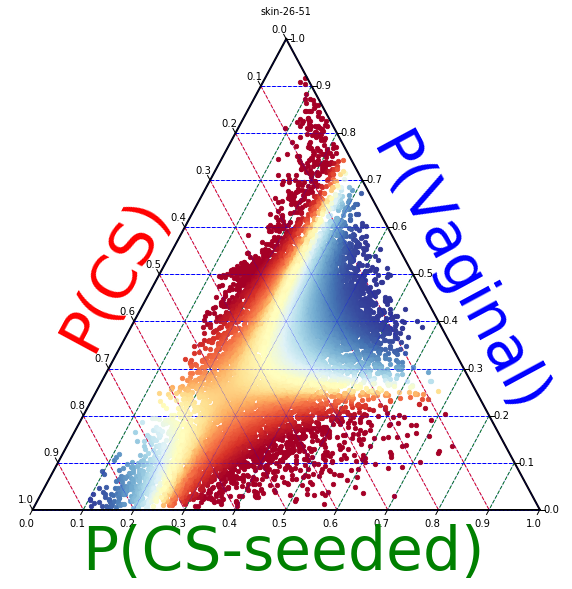

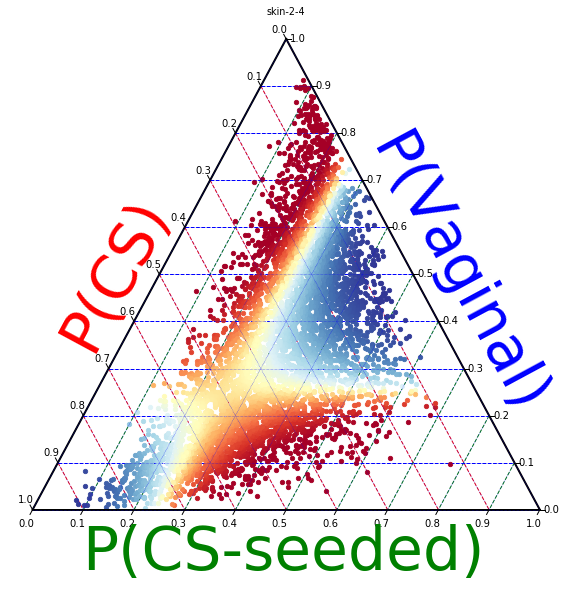

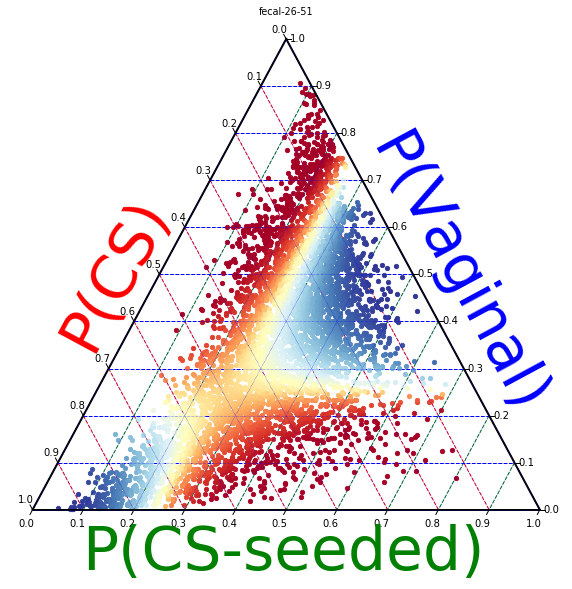

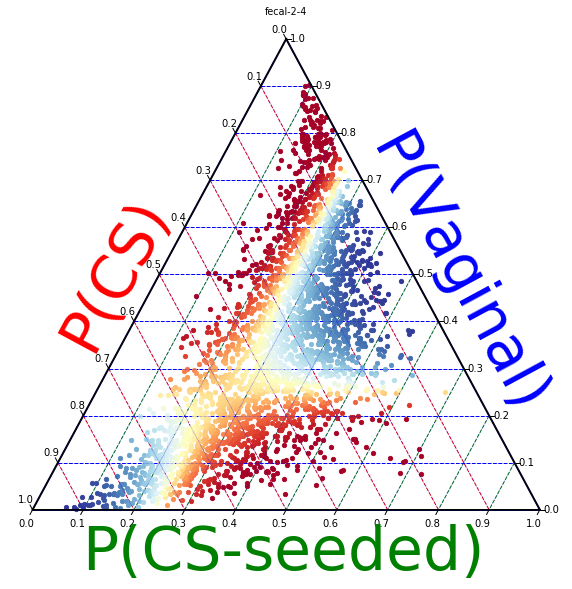

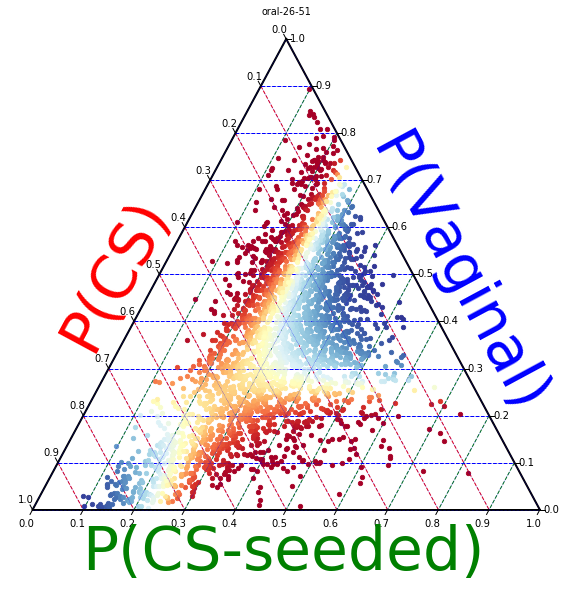

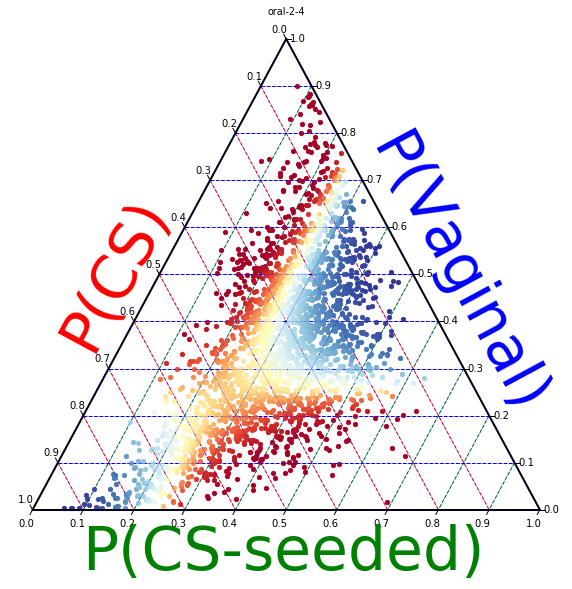

In [13]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': .1}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 20

label_map = {('fecal', '2-4'):'fecal-top-left',
             ('fecal', '26-51'):'fecal-top-right',
             ('oral', '2-4'):'oral-top-left',
             ('oral', '26-51'):'oral-top-right',
             ('skin', '2-4'):'skin-top-left',
             ('skin', '26-51'):'skin-top-right'}

# plot ternary for each diff.
for bls, diffplt in all_differentials.items():
    # columns to plot
    col = ['P(CS-seeded)', 'P(Vaginal)', 'P(CS)']
    # color by:
    hue_ = 'seeding-effectiveness'
    # make the plot
    tax, cdiff = probability_ternary(diffplt, col, hue_)
    # re-save diff with colormap
    all_differentials[bls] = cdiff
    # set title to keep track
    tax.set_title('-'.join(bls))
    # save fig
    tax.savefig('../results/Figure-1c-ternary-%s.pdf' % label_map[bls],
                dpi=1000)
    # view results
    tax.show()

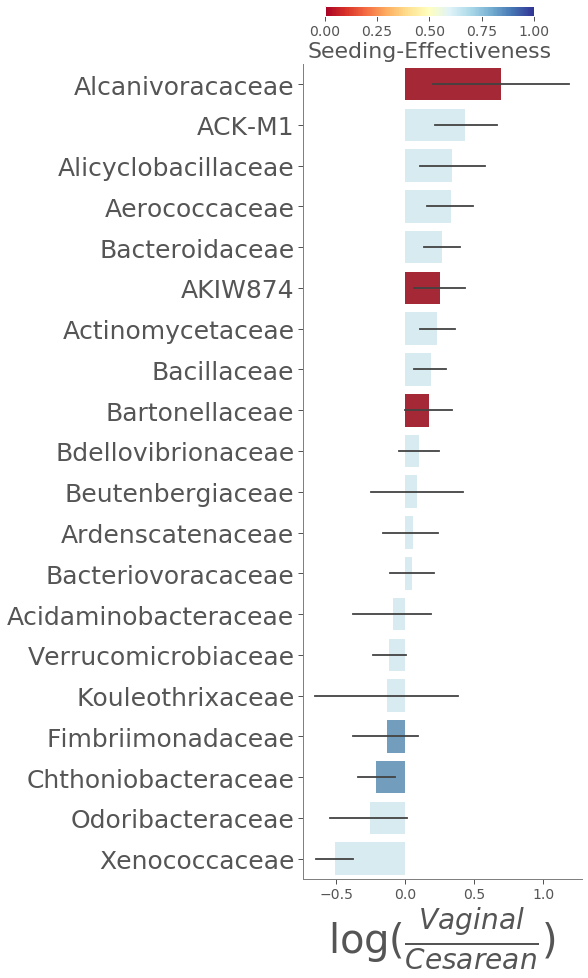

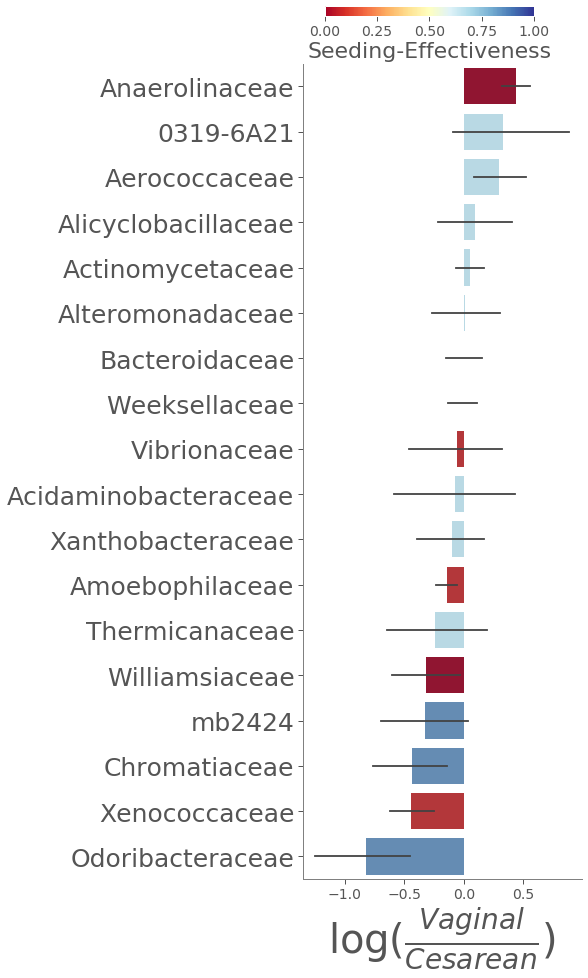

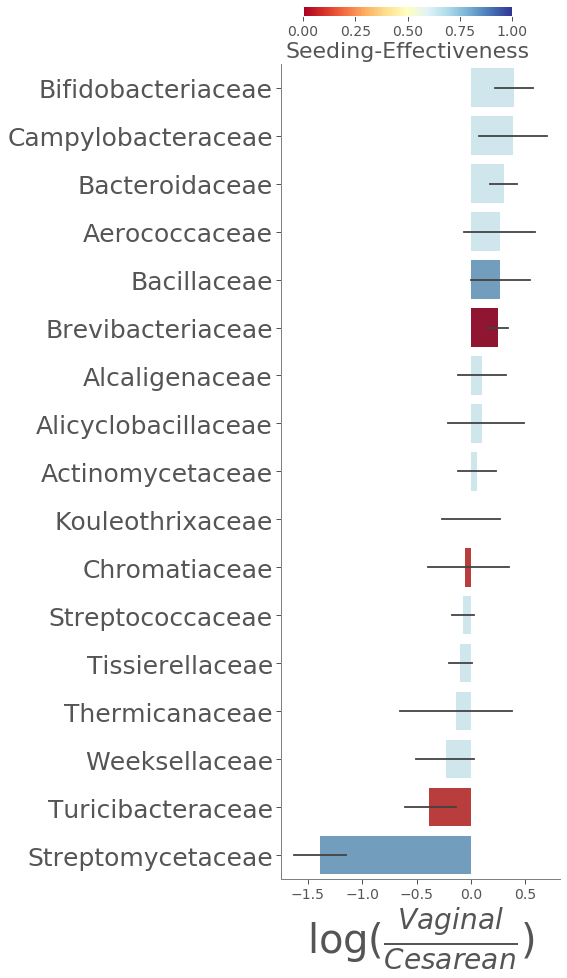

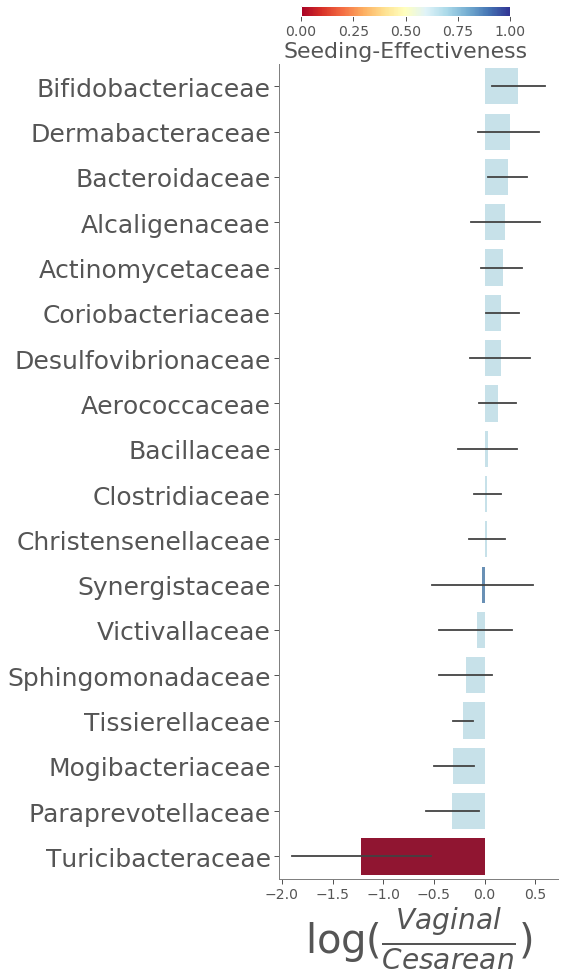

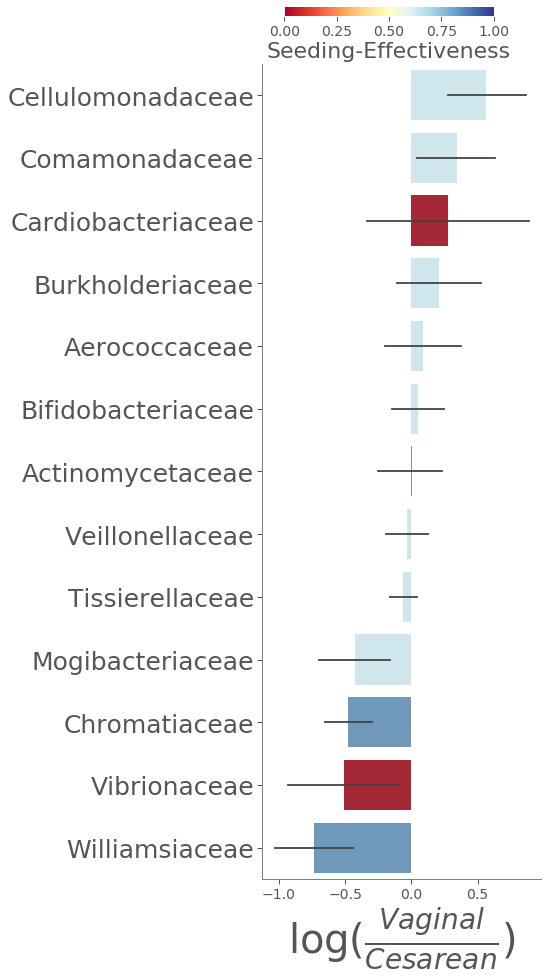

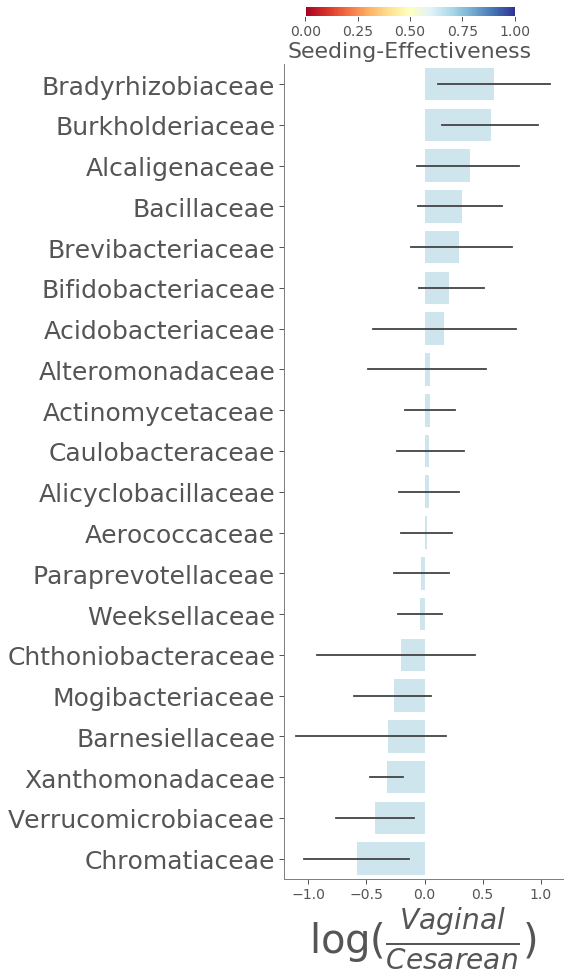

In [15]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': .1}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 25

limits = {'skin':[.2,.8],
           'oral':[.25,.75],
           'fecal':[.25,.75]}
taxonomy_level = 'family'
diff_col = 'C(birth_mode, Treatment("CS"))[T.Vag]'
color = 'seeding-effectiveness'
cmap = 'color-map'
# plot log(V/CS) differential's for each diff.
for bls, diffplt in all_differentials.items():
    # columns to plot
    col = ['P(CS-seeded)', 'P(Vaginal)', 'P(CS)']
    # color by:
    hue_ = 'seeding-effectiveness'
    # make the plot
    fig, ax = plt.subplots(1,1, figsize=(5, 15))
    ax = differential_plot(diffplt, taxonomy_level,
                           color, cmap, diff_col, ax,
                           quartile_partition=False,
                           n_top_bottom_filter=True,
                           n_top_bottom=30)
    #ax.set_xlim(-3.5,)
    # set title to keep track
    ax.set_title('-'.join(bls))    
    # save fig
    plt.savefig('../results/Figure-1c-differentials-%s.pdf' 
                % label_map[bls].replace('top','bottom'),
                dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    ax.set_title('')    
    # view results
    plt.show()

